In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import rasterio as rio
import rioxarray
import math
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import pandas as pd
import os

import deep_snow.models
from deep_snow.utils import calc_norm, undo_norm, calc_dowy
from deep_snow.dataset import norm_dict
from tqdm import tqdm
import shutil

/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/ayushg/miniforge3/envs/deep-snow/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warnin

#### Creating Random Grid for Sampling

In [740]:
xgrid = 30
ygrid = 4
X_coords = np.arange(np.random.randint(-160, -140), 128+160, xgrid)
Y_coords = np.arange(np.random.randint(-160, -140), 128+160, ygrid)
xv, yv = np.meshgrid(X_coords, Y_coords)
xv, yv = xv.flatten(), yv.flatten()

rot = np.deg2rad(25)

xv_rot = (xv*np.cos(rot) + yv*np.sin(rot)).astype('int')
yv_rot = (yv*np.cos(rot) - xv*np.cos(rot)).astype('int')

mask1 = (xv>0)&(xv<128)&(yv>0)&(yv<128)
mask2 = (xv_rot>0)&(xv_rot<128)&(yv_rot>0)&(yv_rot<128)

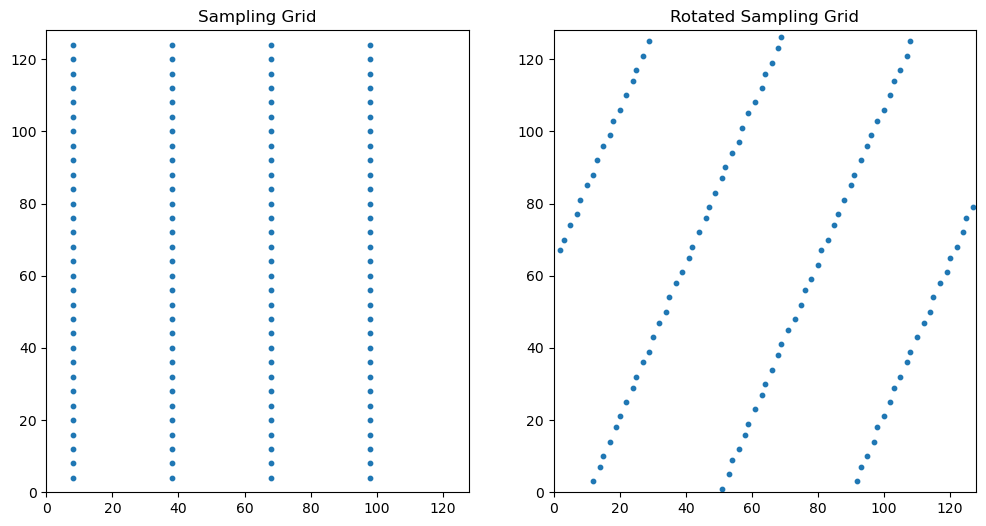

In [744]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(xv[mask1], yv[mask1], s=10)
axs[1].scatter(xv_rot[mask2], yv_rot[mask2], s=10)

axs[0].set_title('Sampling Grid')
axs[1].set_title('Rotated Sampling Grid')
axs[0].set_xlim(0, 128)
axs[1].set_xlim(0, 128)
axs[0].set_ylim(0, 128)
axs[1].set_ylim(0, 128)

plt.savefig('sampling_data.png', bbox_inches='tight',
            dpi=300, transparent=True)

plt.show()

#### Saving to pickle file of Random Sampling Grid

In [745]:
def random_grid(grid_sz_x=30, grid_sz_y=30):
    # Hard coded patch size
    X_coords = np.arange(np.random.randint(-160, -140), 128+160, grid_sz_x)
    Y_coords = np.arange(np.random.randint(-160, -140), 128+160, grid_sz_y)
    xv, yv = np.meshgrid(X_coords, Y_coords)
    xv, yv = xv.flatten(), yv.flatten()

    rot = np.deg2rad(np.random.randint(0, 50)) 

    xv_rot = (xv*np.cos(rot) + yv*np.sin(rot)).astype('int')
    yv_rot = (yv*np.cos(rot) - xv*np.cos(rot)).astype('int')
    mask2 = (xv_rot>0)&(xv_rot<128)&(yv_rot>0)&(yv_rot<128)

    return xv_rot[mask2], yv_rot[mask2]

In [747]:
dataset_list = {}
xgrid, ygrid = 30, 4
for i, file in enumerate(files):
    filenm = file.split('/')[-1].replace('.nc', '')
    xv, yv = random_grid(grid_sz_x=xgrid, grid_sz_y=ygrid)
    dataset_list[filenm] = { 'x_idx': list(xv), 'y_idx': list(yv) }

In [748]:
import pickle
out_path = f'/Users/ayushg/Desktop/Courses/ML_GEO/mlgeo-2024-deep-snow/final_data/jack_subsets 2/dataset_index_{xgrid}_{ygrid}.pkl'
with open(out_path, "wb") as fp:
    pickle.dump(dataset_list, fp)

In [749]:
# Read dictionary pkl file
with open(out_path, 'rb') as fp:
    dataset_idx = pickle.load(fp)

In [750]:
lens = []
for key in dataset_idx.keys():
    xi = dataset_idx[key]['x_idx']
    lens.append(len(xi))

print("Max length of indices", max(lens))

Max length of indices 160


## Training using Sparse Supervision

#### Creating dataloader using sampling points

We are going to sample the sparse points during training, while during test and validation we will be sampling the entire image to evaludate the performance on the entire image. 

In [2]:
norm_dict = {'aso_sd':[0, 25],
             'vv':[-59, 30],
             'vh':[-65, 17],
             'cr':[-43, 16],
             'delta_cr':[-33, 27],
             'AOT':[0, 572],
             'coastal':[0, 24304],
             'blue':[0, 23371],
             'green':[0, 26440],
             'red':[0, 21576],
             'red_edge1':[0, 20796],
             'red_edge2':[0, 20432],
             'red_edge3':[0, 20149],
             'nir':[0, 21217],
             'water_vapor':[0, 18199],
             'swir1':[0, 17669],
             'swir2':[0, 17936],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6518],
             'elevation':[-100, 9000],
             'aspect':[0, 360],
             'slope':[0, 90],
             'curvature':[-22, 22],
             'tpi':[-164, 167],
             'tri':[0, 913],
             'latitude':[-90, 90],
             'longitude':[-180, 180],
             'dowy': [0, 365]}

def compute_maxlen(out_path):
    # Read dictionary pkl file
    with open(out_path, 'rb') as fp:
        dataset_idx = pickle.load(fp)
    lens = []

    for key in dataset_idx.keys():
        xi = dataset_idx[key]['x_idx']
        lens.append(len(xi))

    return max(lens)


# Process each file and normalize the relevant features
def process_file(file_path):
    ds = xr.open_dataset(file_path)
    # Normalize features using the norm_dict
    data_dict = {}
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['slope'] = calc_norm(torch.Tensor(ds['slope'].values), norm_dict['slope'])
    data_dict['tri'] = calc_norm(torch.Tensor(ds['tri'].values), norm_dict['tri'])
    data_dict['tpi'] = calc_norm(torch.Tensor(ds['tpi'].values), norm_dict['tpi'])
    data_dict['dowy'] = calc_norm(torch.Tensor(ds['dowy'].values), norm_dict['dowy'])
    # Reshape PC components to 2D
    s1_pc1_2d = ds['s1_pc1'].values.reshape(128, 128)
    s1_pc2_2d = ds['s1_pc2'].values.reshape(128, 128)
    s2_pc1_2d = ds['s2_pc1'].values.reshape(128, 128)
    s2_pc2_2d = ds['s2_pc2'].values.reshape(128, 128)
    s2_pc3_2d = ds['s2_pc3'].values.reshape(128, 128)
    # Stack normalized features
    features = np.stack([
        data_dict['elevation'].numpy(),
        data_dict['slope'].numpy(),
        data_dict['tri'].numpy(),
        data_dict['tpi'].numpy(),
        data_dict['latitude'].numpy(),
        data_dict['longitude'].numpy(),
        s1_pc1_2d,
        s1_pc2_2d,
        s2_pc1_2d,
        s2_pc2_2d,
        s2_pc3_2d,
        data_dict['dowy'].numpy()
    ], axis=0)
    target = ds['aso_sd'].values
    return features, target

In [1]:
import pickle
from torch.utils.data import DataLoader, Dataset

# For computing mean and std for normalisation of snow_depth
# And potentially using histogram distribution of these points for weighted loss (penalising the model more on less frequent values compared to more frequent values)
def compute_train_mean_std(ds_train, num_samples=None, num_workers=8, batch_size=128, max_len=160, return_distribution=False, bin_edges=None, collate_fn=None):
    """
    Compute training statistics (mean and standard deviation) per tensor channel (with channel axis=1).
    Can be used for multi-channel inputs and single channel targets
    Args:
        ds_train: torch dataset
        data_key: string name of torch tensor with shape (channels, height, width). (e.g. 'inputs', 'labels_mean')
        num_samples: max number of patches used to calculate the statistics
        num_workers: number of workers used in dataloader
        return_distribution: bool, if True: returns the number of samples per bin
        bin_edges: used to return the number of sampler per bin

    Returns:
        train_mean: numpy array with shape (channels,)
        train_std: numpy array with shape (channels,)
    """
    max_range = 1.7e308  # max range for float64

    dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=lambda b: collate_fn(b, False, True, max_len))

    with torch.no_grad():
        # get the dimensions from the first sample
        for batch_idx, batch in enumerate(dl_train):
            _, first_sample, _ = batch

            _, channels, length = first_sample.unsqueeze(1).shape
            break
        print('channels, height, width: ', channels, length)
    
        # init torch tensors
        sum_ = torch.zeros(channels, dtype=torch.float64)
        sum_sq_ = torch.zeros(channels, dtype=torch.float64)
        count_ = torch.zeros(1, dtype=torch.float64)  # assume equal count for each channel (image or labels)

        if return_distribution:
            if bin_edges is None:
                bin_edges = np.arange(0, 101, 1)
            bin_num_samples = np.zeros(len(bin_edges)-1, dtype=np.float64)

        for batch_idx, batch in enumerate(tqdm(dl_train, ncols=100, desc='stats')):  # for each training step
            
            _, Y, index = batch
            # stop when num_samples are sampled
            if batch_idx >= int(num_samples/batch_size):
                print('Loaded {} samples to compute channel statistics.'.format(num_samples))
                break

            sum_ = sum_ + torch.nansum(Y, axis=(0, 1))
            sum_sq_ = sum_sq_ + torch.nansum((Y ** 2), axis=(0, 1))
            count_ = count_ + torch.sum(~torch.isnan(Y[:, ...]))  # use the first channel because we want the count per channel to compute image channel statistics

            if return_distribution:
                hist, bin_edges = np.histogram(Y, bins=bin_edges)
                bin_num_samples = bin_num_samples + hist

            # check overflow
            if torch.any(sum_sq_ >= max_range):
                print('sum_sq_: ', sum_sq_)
                raise OverflowError('sum_sq_ is too large')

        train_mean = sum_ / count_
        train_mean_sq_ = sum_sq_ / count_
        train_std = torch.sqrt(train_mean_sq_ - train_mean ** 2)

        # cast to numpy float32
        train_mean = train_mean.cpu().numpy().astype(np.float32)
        train_std = train_std.cpu().numpy().astype(np.float32)

    if return_distribution:
        return train_mean, train_std, bin_num_samples, bin_edges
    else:
        return train_mean, train_std
        

In [ ]:
def get_inverse_bin_frequency_weights(labels, bin_edges, bin_weights):
    bin_indices = np.digitize(labels, bin_edges, right=False) - 1  # to start with index=0
    bin_indices = np.clip(bin_indices, 0, len(bin_edges) - 2)
   # handle nan labels: nans map to len()
    nan_mask = np.isnan(labels)
    bin_indices[nan_mask] = 0
    # print(bin_indices, labels, bin_weights)
    sample_weights = bin_weights[bin_indices].astype(np.float32)    
    return sample_weights


class SparseSnowDataset(Dataset):
    """Sparse Snow Depth dataset"""
    def __init__(self, datapath, idx_filename, mode, get_target=False, get_weights=False, bin_edges=None, bin_weights=None):
        self.datapath = datapath
        self.data_files = glob(f'{datapath}/ncs/*.nc')

        # Calculate the sizes for each split
        train_size = int(0.7 * len(self.data_files))  # 70% for training
        test_size = int(0.2 * len(self.data_files))   # 20% for testing
        val_size = len(self.data_files) - train_size - test_size  # Remaining 10% for validation

        # Setting modes
        if mode=='train':
            self.data_files = self.data_files[:train_size]
        elif mode=='test':
            self.data_files = self.data_files[train_size:train_size + test_size]
        elif mode=='val':
            self.data_files = self.data_files[train_size + test_size:]

        # Read dictionary pkl file
        with open(f'{datapath}/{idx_filename}', 'rb') as fp:
            self.dataset_idx = pickle.load(fp)

        self.data_file_name = {}
        for file in tqdm(self.data_files):
            features, target = process_file(file)
            self.data_file_name[file] = {'features': features, 'target': target}

        self.get_target = get_target
        self.get_weights = get_weights
        if get_weights:
            self.bin_edges = bin_edges
            self.bin_weights = bin_weights

    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, index):
        file_name = self.data_files[index]
        features, target = self.data_file_name[file_name]['features'], self.data_file_name[file_name]['target']
        # features, target = process_file(file_name)
        xy_grid = self.dataset_idx[file_name.split('/')[-1].replace('.nc', '')]
        x_idx, y_idx = xy_grid['x_idx'], xy_grid['y_idx']
        index = np.array((np.array(y_idx) * features.shape[-1]) + np.array(x_idx))
        if self.get_target:
            target = torch.gather(torch.flatten(torch.tensor(target), start_dim=0), 0, torch.tensor(index))
            if self.get_weights:
                sample_weights = get_inverse_bin_frequency_weights(target, self.bin_edges, self.bin_weights)
                return features, target, index, sample_weights

        return features, target, index

In [5]:
MAX_IDX_LENGTH = 25

def collate_fn(batch, get_weights=False, get_target=False, max_length=160):
    features  = []
    targets = []
    idxs = []
    weights = []
    for batch_ele in batch:
        if get_weights:
            feature, target, idx, weight = batch_ele
        else:
            feature, target, idx = batch_ele

        features.append(feature)
        padding = max_length - idx.shape[0]
        if padding > 0:
            idxs.append(F.pad(torch.tensor(idx), (0, padding), "constant", 0))
            if get_weights:
                weights.append(F.pad(torch.tensor(weight), (0, padding), "constant", 0))
            if get_target:
                targets.append(F.pad(target, (0, padding), "constant", 0))
            else:
                targets.append(torch.tensor(target, dtype=torch.float))
        else:
            idxs.append(torch.tensor(idx))
            if get_weights:
                weights.append(torch.tensor(weight))
            if get_target:
                targets.append(torch.tensor(target))
            else:
                targets.append(torch.tensor(target, dtype=torch.float))
    
    if get_weights:
        return torch.tensor(features, dtype=torch.float), torch.stack(targets), torch.stack(idxs), torch.stack(weights)
    if get_target:
        return torch.tensor(features, dtype=torch.float), torch.stack(targets), torch.stack(idxs)
    else:
        return torch.tensor(features, dtype=torch.float), torch.stack(targets)


In [ ]:
# Creating train, validation, and test dataloaders
data_path = '/Users/ayushg/Desktop/Courses/ML_GEO/mlgeo-2024-deep-snow/final_data/jack_subsets 2'
idx_fn = 'dataset_index_30_4.pkl'

max_len = compute_maxlen(f'{data_path}/{idx_fn}')
train_snow_dataset = SparseSnowDataset(data_path, idx_fn, 'train', get_target=True)
target_mean, target_std, bin_num_samples, bin_edges = compute_train_mean_std(train_snow_dataset, max_len=max_len, bin_edges=np.arange(0, 6, 0.5), num_samples=len(train_snow_dataset), return_distribution=True, collate_fn=collate_fn)
bin_weights = np.sqrt(1/bin_num_samples)/np.sqrt(1/bin_num_samples).sum()

train_snow_dataset = SparseSnowDataset(data_path, idx_fn, 'train', get_target=True, get_weights=True, bin_edges=bin_edges, bin_weights=bin_weights)
val_snow_dataset = SparseSnowDataset(data_path, idx_fn, 'val', get_target=False, get_weights=False)
test_snow_dataset = SparseSnowDataset(data_path, idx_fn, 'test', get_target=False, get_weights=False)

# # Create data loaders
train_loader = DataLoader(train_snow_dataset, batch_size=32, shuffle=True, collate_fn=lambda b: collate_fn(b, True, True, max_len))
test_loader = DataLoader(test_snow_dataset, batch_size=32, shuffle=False, collate_fn=lambda b: collate_fn(b, False, False, max_len))
val_loader = DataLoader(val_snow_dataset, batch_size=32, shuffle=False, collate_fn=lambda b: collate_fn(b, False, False, max_len))

100%|██████████| 2478/2478 [02:39<00:00, 15.55it/s]
/var/folders/q7/4r0lxc6j59lf_bjt9p2p0y8h0000gp/T/ipykernel_1275/2111274140.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets.append(torch.tensor(target))
/var/folders/q7/4r0lxc6j59lf_bjt9p2p0y8h0000gp/T/ipykernel_1275/2111274140.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.tensor(features, dtype=torch.float), torch.stack(targets), torch.stack(idxs)


channels, height, width:  1 160


stats:  24%|█████████████▋                                          | 19/78 [00:18<00:57,  1.03it/s]


Loaded 2478 samples to compute channel statistics.


100%|██████████| 708/708 [00:45<00:00, 15.59it/s]


### Model Architecture

We are just picking a simple CNN for evaluating if sparse supervision helps or not.

In [7]:
class SnowDepthCNN(nn.Module):
    def __init__(self):
        super(SnowDepthCNN, self).__init__()
        # First conv layer: (12, 128, 128) -> (32, 128, 128)
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Second conv layer: (32, 128, 128) -> (16, 128, 128)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        # Final conv layer: (16, 128, 128) -> (1, 128, 128)
        self.pred = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
        self.var = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1),
                                 nn.ReLU(inplace=False))

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        pred = self.pred(x)
        var = self.var(x)
        return pred.squeeze(1), var.squeeze(1)  # Remove channel dimension to match target shape

In [ ]:
class GaussianNLL(nn.Module):
    """
    Gaussian negative log likelihood to fit the mean and variance to p(y|x)
    Note: We estimate the heteroscedastic variance. Hence, we include the var_i of sample i in the sum
    over all samples N. Furthermore, the constant log term is discarded.
    """
    def __init__(self, reduction='mean'):
        super(GaussianNLL, self).__init__()
        self.eps = 1e-8
        self.reduction = reduction

    def __call__(self, prediction, variance, target, mask=None):
        variance = variance + self.eps
        if self.reduction == 'mean':
            return torch.mean((0.5 / variance * (prediction - target)**2 + 0.5 * torch.log(variance))[~mask])
        elif self.reduction == 'none':
            return 0.5 / variance * (prediction - target)**2 + 0.5 * torch.log(variance)


class SparseMAE(nn.Module):
    def __init__(self, reduction='mean'):
        super(SparseMAE, self).__init__()
        self.reduction = reduction

    def __call__(self, prediction, variance, target, mask):
        if self.reduction == 'mean':
            return torch.mean(F.l1_loss(prediction, target, reduction='none')[~mask])
        elif self.reduction == 'none':
            return F.l1_loss(prediction, target, reduction='none')


class SampleWeightedLoss(nn.Module):
    '''
    Weighted loss are computed to account for the class imbalance in data
    Less frequent values are penalized more compared to more frequent values
    '''
    def __init__(self, loss_key='MAE', norm_batch=True):
        super(SampleWeightedLoss, self).__init__()
        self.loss_key = loss_key

        if loss_key == 'MSE':
            self.loss_fun = torch.nn.MSELoss(reduction='none')
        elif loss_key == 'MAE':
            self.loss_fun = torch.nn.L1Loss(reduction='none')
        elif loss_key == 'GNLL':
            self.loss_fun = GaussianNLL(reduction='none')
        else:
            raise ValueError('Sample weighted loss is not yet implemented for loss_key={}'.format(loss_key))

    def __call__(self, output, target, sample_weights=None, variance=None, mask=None):
        if self.loss_key!='GNLL':
            loss_values = self.loss_fun(output, target)
        else:
            loss_values = self.loss_fun(output, variance, target)
        
        if mask is None:
            loss = torch.mul(loss_values, sample_weights)[~mask].sum()
        else:
            loss = loss_values.mean()
        return loss

In [796]:
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion_train, criterion_test, optimizer, num_epochs, device, norm_mean, norm_std):
    """
    Train, validate, and test the model.

    Args:
        model (nn.Module): The PyTorch model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (Loss): The loss function.
        optimizer (Optimizer): The optimizer for model training.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to use for computation.

    Returns:
        tuple: A tuple containing training losses, validation losses, and final test loss.
    """
    train_losses = []
    val_losses = []
    get_weight = True
    norm_std = torch.tensor(norm_std).to(device)
    norm_mean = torch.tensor(norm_mean).to(device)
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            if get_weight:
                features, targets, index, weights = batch
                features, targets, index, weights = features.to(device), targets.to(device), index.to(device), weights.to(device)

            targets = (targets - norm_mean)/norm_std
            
            optimizer.zero_grad()
            preds, variances = model(features)

            # Getting sparse elements from array
            mask = (index[:,:]<=0)
            sparse_pred = torch.gather(torch.flatten(preds, start_dim=1), 1, index)
            sparse_var = torch.gather(torch.flatten(variances, start_dim=1), 1, index)
            # sparse_target = torch.gather(torch.flatten(targets, start_dim=1), 1, index)

            loss = criterion_train(sparse_pred, targets, weights, sparse_var, mask=mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        # It can be performed on entire target data (ASO Snow Depth)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs, _ = model(features)
                outputs = outputs*norm_std + norm_mean
                val_loss += criterion_test(outputs, targets).item()
        
        # Compute average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
    
    # Testing
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            
            outputs, _ = model(features)
            test_loss += criterion_test(outputs, targets).item()

    final_test_loss = test_loss / len(test_loader)
    print(f'\nFinal Test Loss: {final_test_loss:.4f}')

    return train_losses, val_losses, final_test_loss

In [ ]:
model = SnowDepthCNN()

loss_sample = SampleWeightedLoss(loss_key='GNLL')
loss_mae = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = 'cpu'
model = model.to(device)
print(device)

train_losses2, val_losses2, test_loss2 = train_and_evaluate_model(
    model=model.to(device),
    train_loader=train_loader,
    val_loader=val_loader,  
    test_loader=test_loader,
    criterion_train=loss_sample,
    criterion_test=loss_mae,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    norm_mean=target_mean, norm_std=target_std
)

mps


Epoch 1:   4%|▍         | 3/78 [00:02<01:01,  1.22it/s]/var/folders/q7/4r0lxc6j59lf_bjt9p2p0y8h0000gp/T/ipykernel_21442/2111274140.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets.append(torch.tensor(target))
Epoch 1: 100%|██████████| 78/78 [01:02<00:00,  1.26it/s]


Epoch [1/10]
Training Loss: 4009622087.2051
Validation Loss: 0.8237


Epoch 2: 100%|██████████| 78/78 [01:02<00:00,  1.25it/s]


Epoch [2/10]
Training Loss: 443236.6814
Validation Loss: 0.8235


Epoch 3: 100%|██████████| 78/78 [01:01<00:00,  1.26it/s]


Epoch [3/10]
Training Loss: 983.4651
Validation Loss: 0.8235


Epoch 4: 100%|██████████| 78/78 [01:01<00:00,  1.26it/s]


Epoch [4/10]
Training Loss: 947.4884
Validation Loss: 0.8235


Epoch 5: 100%|██████████| 78/78 [01:01<00:00,  1.26it/s]


Epoch [5/10]
Training Loss: 944.2229
Validation Loss: 0.8235


Epoch 6: 100%|██████████| 78/78 [01:02<00:00,  1.26it/s]


Epoch [6/10]
Training Loss: 940.0411
Validation Loss: 0.8234


Epoch 7: 100%|██████████| 78/78 [01:01<00:00,  1.27it/s]


Epoch [7/10]
Training Loss: 935.4200
Validation Loss: 0.8234


Epoch 8: 100%|██████████| 78/78 [01:01<00:00,  1.26it/s]


Epoch [8/10]
Training Loss: 930.2187
Validation Loss: 0.8234


Epoch 9: 100%|██████████| 78/78 [01:02<00:00,  1.25it/s]


Epoch [9/10]
Training Loss: 924.6778
Validation Loss: 0.8234


Epoch 10: 100%|██████████| 78/78 [01:02<00:00,  1.25it/s]


Epoch [10/10]
Training Loss: 918.7305
Validation Loss: 0.8234

Final Test Loss: 0.6409
